In [1]:
import torch
import cvxpy as cp
import numpy as np
from cvxpylayers.torch import CvxpyLayer
from scipy.linalg import sqrtm
from scipy.linalg import solve_discrete_are

In [2]:
np.random.seed(0)

# generate problem data
n, m = 4, 2
noise = np.sqrt(0.25)
Q0 = np.eye(n)
R0 = np.eye(m)
A = np.random.randn(n, n)
A /= np.max(np.abs(np.linalg.eig(A)[0]))
B = np.random.randn(n, m)
W = noise**2 * np.eye(n)

In [3]:
# compute lqr solution
P = cp.Variable((n, n), PSD=True)
R0cvxpy = cp.Parameter((m, m), PSD=True)

objective = cp.trace(P@W)
constraints = [cp.bmat([
    [R0cvxpy + B.T@P@B, B.T@P@A],
    [A.T@P@B, Q0+A.T@P@A-P]
]) >> 0, P >> 0]
R0cvxpy.value = R0
result = cp.Problem(cp.Maximize(objective), constraints).solve()
P_lqr = P.value
print(result)

1.8031178751626373


In [4]:
P_lqr

array([[1.854, 0.122, 0.516, 1.053],
       [0.122, 1.182, 0.096, 0.448],
       [0.516, 0.096, 1.315, 0.676],
       [1.053, 0.448, 0.676, 2.861]])

In [5]:
# set up policy
x = cp.Parameter((n, 1))
P_sqrt = cp.Parameter((n, n))

u = cp.Variable((m, 1))
xnext = cp.Variable((n, 1))

objective = cp.quad_form(u, R0) + cp.sum_squares(P_sqrt @ xnext)
constraints = [xnext == A @ x + B @ u]
prob = cp.Problem(cp.Minimize(objective), constraints)
policy = CvxpyLayer(prob, [x, P_sqrt], [u])

In [6]:
# initialize parameters
Qt, Rt, At, Bt = map(torch.from_numpy, [Q0, R0, A, B])
P_sqrt = torch.eye(n).double(); P_sqrt.requires_grad_(True);

In [7]:
def loss(time_horizon, batch_size, P_sqrt, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    x_batch = torch.randn(batch_size, n, 1).double()
    P_sqrt_batch = P_sqrt.repeat(batch_size, 1, 1)
    Qt_batch = Qt.repeat(batch_size, 1, 1)
    Rt_batch = Rt.repeat(batch_size, 1, 1)
    At_batch = At.repeat(batch_size, 1, 1)
    Bt_batch = Bt.repeat(batch_size, 1, 1)
    loss = 0.0
    for _ in range(time_horizon):
        u_batch, = policy(x_batch, P_sqrt_batch, solver_args={"acceleration_lookback": 0})
        state_cost = torch.bmm(torch.bmm(Qt_batch, x_batch).transpose(2, 1), x_batch)
        control_cost = torch.bmm(torch.bmm(Rt_batch, u_batch).transpose(2, 1), u_batch)
        cost_batch = (state_cost.squeeze() + control_cost.squeeze())
        loss += cost_batch.sum() / (time_horizon * batch_size)
        x_batch = torch.bmm(At_batch, x_batch) + \
            torch.bmm(Bt_batch, u_batch) + \
            noise * torch.randn(batch_size, n, 1).double()
    return loss

In [8]:
Kt = np.linalg.solve(R0 + B.T @ P_lqr @ B, -B.T @ P_lqr @ A)
loss_lqr = loss(100, 6, torch.from_numpy(sqrtm(P_lqr)), seed=0).item()

In [10]:
losses = []
opt = torch.optim.SGD([P_sqrt], lr=.5)
test_loss = None
for k in range(50):
    with torch.no_grad():
        test_loss = loss(100, 6, P_sqrt.detach(), seed=0).item()
        K_np = (torch.linalg.solve(-Bt.t() @ P_sqrt.t() @ P_sqrt @ At, Rt + Bt.t() @ P_sqrt.t() @ P_sqrt @ Bt).solution).detach().numpy()
        dist = np.linalg.norm(K_np - Kt)
        P = (P_sqrt.t() @ P_sqrt).detach().numpy()
        dist_P = np.linalg.norm(P_lqr - P)
        losses.append(test_loss)
        print("it: %03d, loss: %3.3f, dist: %3.3f, dist_P: %3.3f" % (k+1, test_loss - loss_lqr, dist, dist_P))
    opt.zero_grad()
    l = loss(100, 6, P_sqrt, seed=k+1)
    l.backward()
    opt.step()
    if k == 25:
        opt = torch.optim.SGD([P_sqrt], lr=.1)

RuntimeError: linalg.solve: A must be batches of square matrices, but they are 4 by 2 matrices

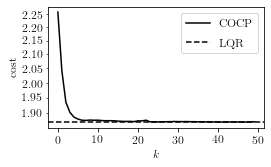

In [53]:
import matplotlib.pyplot as plt
from utils import latexify
import matplotlib

latexify(fig_width=4)
fig, ax = plt.subplots()
plt.xticks([0, 10, 20, 30, 40, 50])
plt.semilogy(losses, color='k', label='COCP')
plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.axhline(loss_lqr, linestyle='--', color='k', label='LQR')
plt.legend()
plt.ylabel("cost")
plt.xlabel("$k$")
plt.subplots_adjust(left=.15, bottom=.2)
plt.savefig("lqr.pdf")
plt.show()